# CounterFactual Experiment

This notebook demonstrates the generation and visualization of counterfactual explanations using DPG constraints.

## Import Libraries

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from typing import cast
from sklearn.utils import Bunch

from CounterFactualModel import CounterFactualModel
from ConstraintParser import ConstraintParser

# Reload the module to get latest changes
import importlib
import CounterFactualVisualizer
importlib.reload(CounterFactualVisualizer)

from CounterFactualVisualizer import (plot_pca_with_counterfactual, plot_sample_and_counterfactual_heatmap, 
                                     plot_pca_loadings, plot_constraints, 
                                     plot_sample_and_counterfactual_comparison, plot_pairwise_with_counterfactual_df)
from CounterFactualExplainer import CounterFactualExplainer

import itertools

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# Define consistent class colors for the entire notebook
CLASS_COLORS = {
    'Class 0': 'purple',
    'Class 1': 'green',
    'Class 2': 'orange'
}

# Alternative: Color list by index
CLASS_COLORS_LIST = ['purple', 'green', 'orange']

## Training Machine Learning Model

In [27]:
iris: Bunch = cast(Bunch, load_iris())
iris_features = iris.data
iris_labels = iris.target

train_features, test_features, train_labels, test_labels = train_test_split(iris_features, iris_labels, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=3, random_state=42)
model.fit(train_features, train_labels)

,n_estimators,3
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Opening Constraints Extracted from DPG

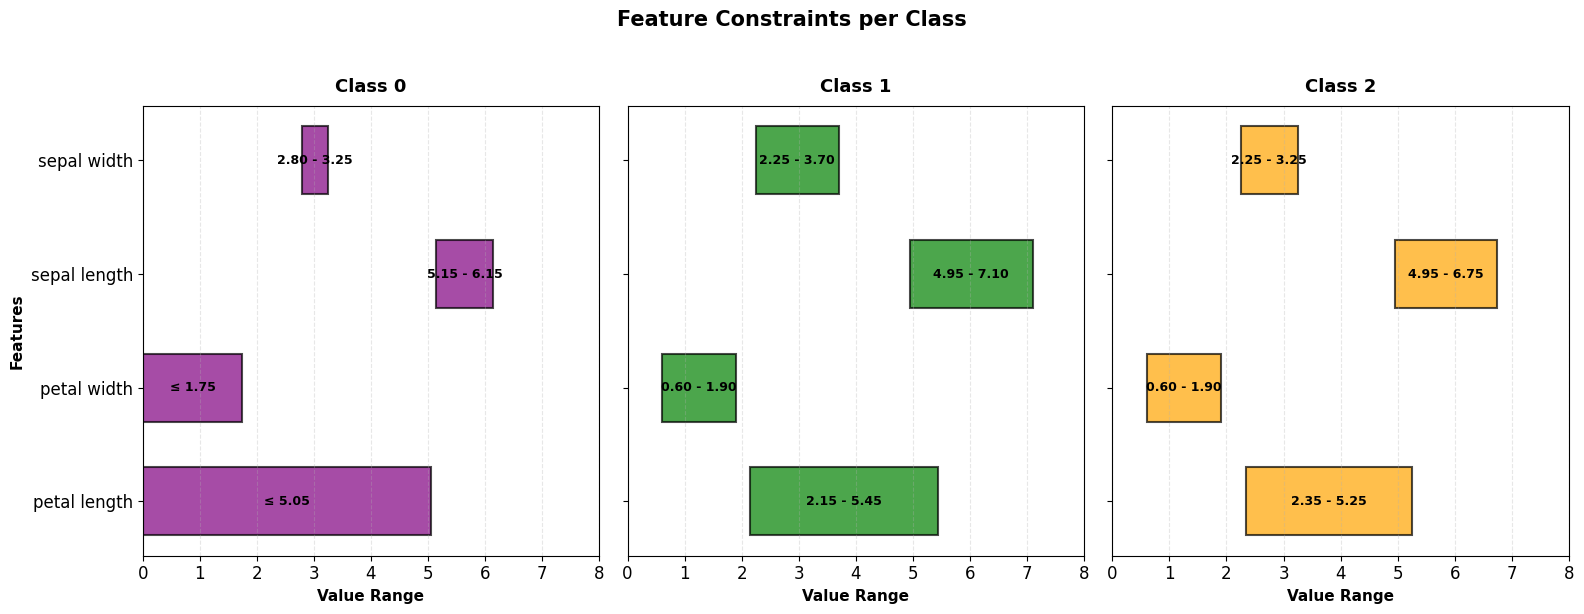

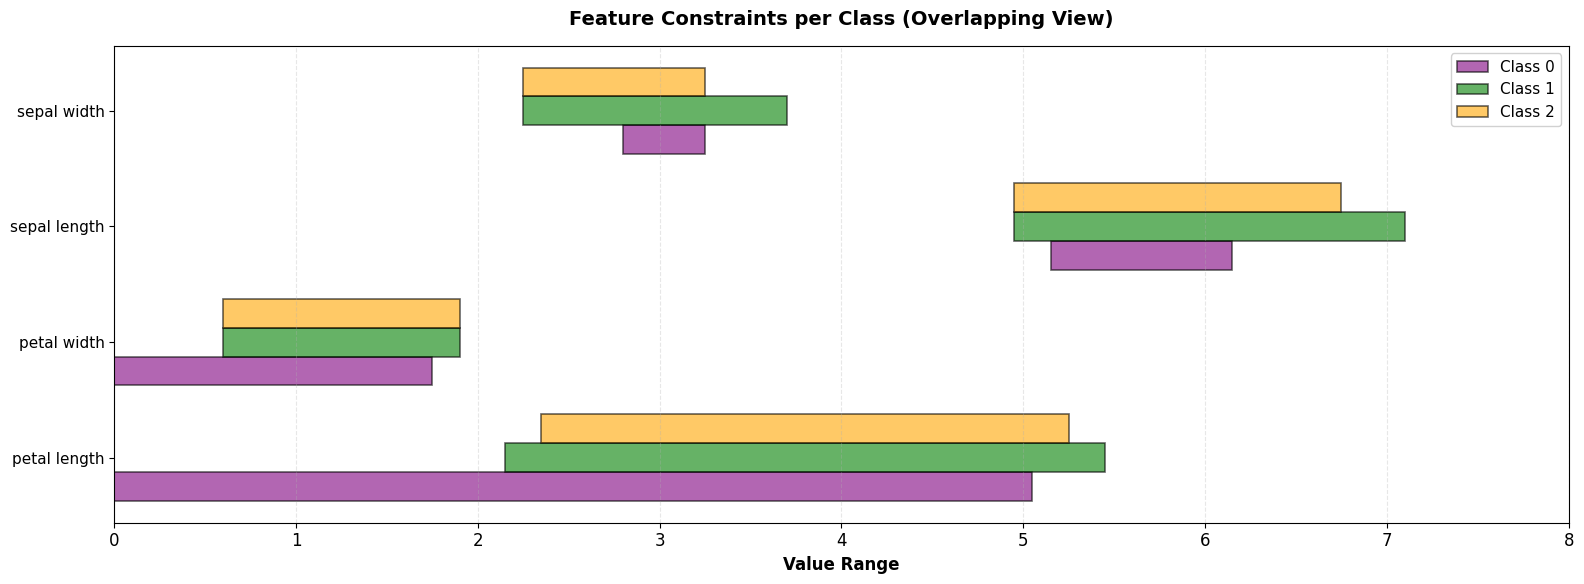

In [28]:
parser = ConstraintParser("constraints/custom_l100_pv0.001_t2_dpg_metrics.txt")
constraints = parser.read_constraints_from_file()
plot_constraints(constraints, overlapping=False, class_colors=CLASS_COLORS, class_colors_list=CLASS_COLORS_LIST)
plot_constraints(constraints, overlapping=True, class_colors=CLASS_COLORS, class_colors_list=CLASS_COLORS_LIST)

## Prepare Sample Data

In [29]:
original_sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
sample_dataframe = pd.DataFrame([original_sample])  # Wrapping sample in a list to create a DataFrame

## Generating Counterfactual Samples

In [30]:
cf_dpg = CounterFactualModel(model, constraints, verbose=True)  # Ensure you are using the correct constraints (nested_dict)
target_class = 0
counterfactual = cf_dpg.generate_counterfactual(original_sample, target_class, 20, 100)

explainer = CounterFactualExplainer(cf_dpg, original_sample, counterfactual, target_class)
print(explainer.explain_feature_modifications())
print(explainer.check_constraints_respect())
print(explainer.explain_stopping_criteria())
print(explainer.summarize_final_results())

****** Generation 1: Average Fitness = 27.9137, Best Fitness = 27.9137, fitness improvement = inf
****** Generation 2: Average Fitness = 27.6263, Best Fitness = 27.4388, fitness improvement = 0.4749
****** Generation 3: Average Fitness = 27.5418, Best Fitness = 26.6371, fitness improvement = 0.8016
****** Generation 4: Average Fitness = 27.4014, Best Fitness = 26.3858, fitness improvement = 0.2513
****** Generation 5: Average Fitness = 26.9038, Best Fitness = 25.5796, fitness improvement = 0.8063
****** Generation 6: Average Fitness = 26.2323, Best Fitness = 24.9653, fitness improvement = 0.6143
****** Generation 7: Average Fitness = 25.3691, Best Fitness = 23.9301, fitness improvement = 1.0352
****** Generation 8: Average Fitness = 24.3208, Best Fitness = 23.2461, fitness improvement = 0.6841
****** Generation 9: Average Fitness = 23.6254, Best Fitness = 22.4117, fitness improvement = 0.8343
****** Generation 10: Average Fitness = 23.1827, Best Fitness = 21.9629, fitness improvement =

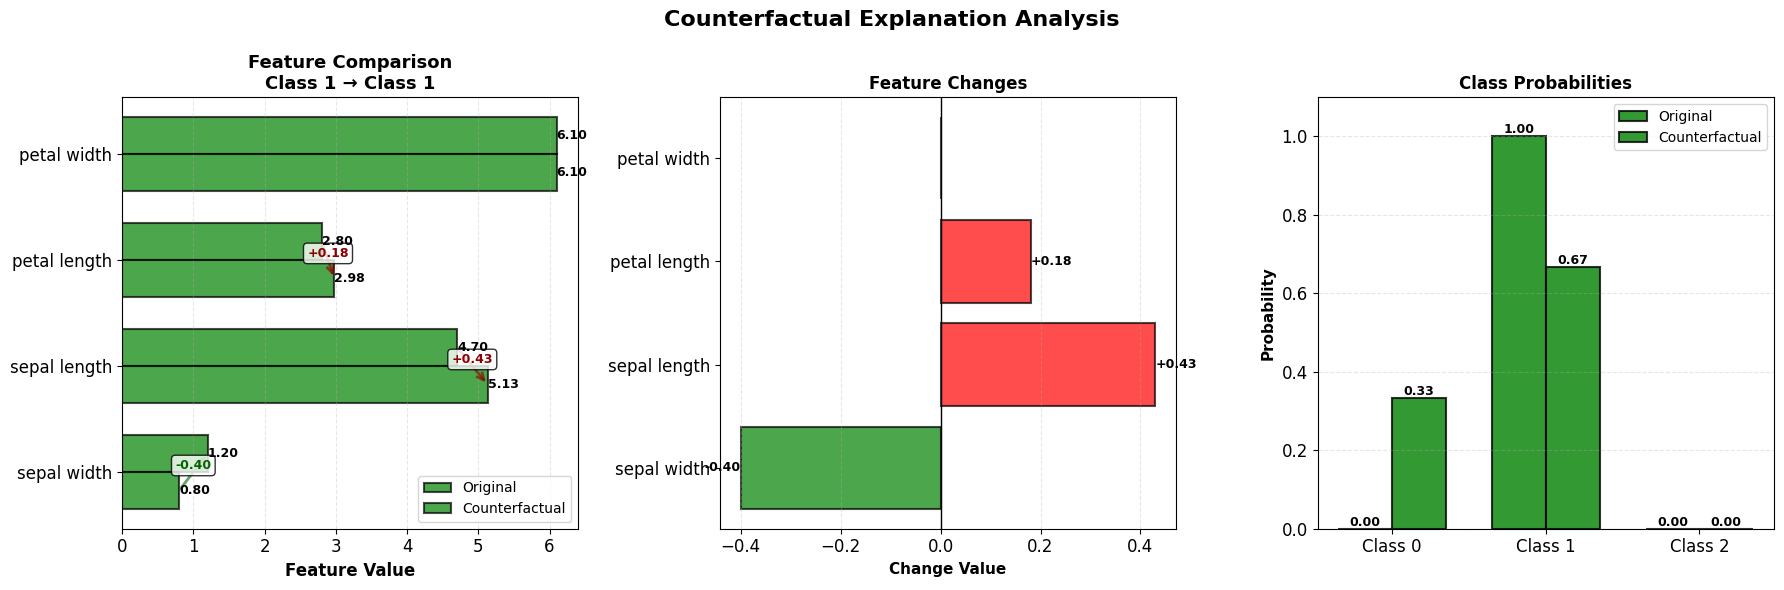

In [31]:
predicted_class = model.predict(sample_dataframe)
counterfactual_class = model.predict(pd.DataFrame([counterfactual]))
plot_sample_and_counterfactual_comparison(model, original_sample, sample_dataframe, counterfactual, CLASS_COLORS_LIST)

## Visualizing Counterfactual Samples

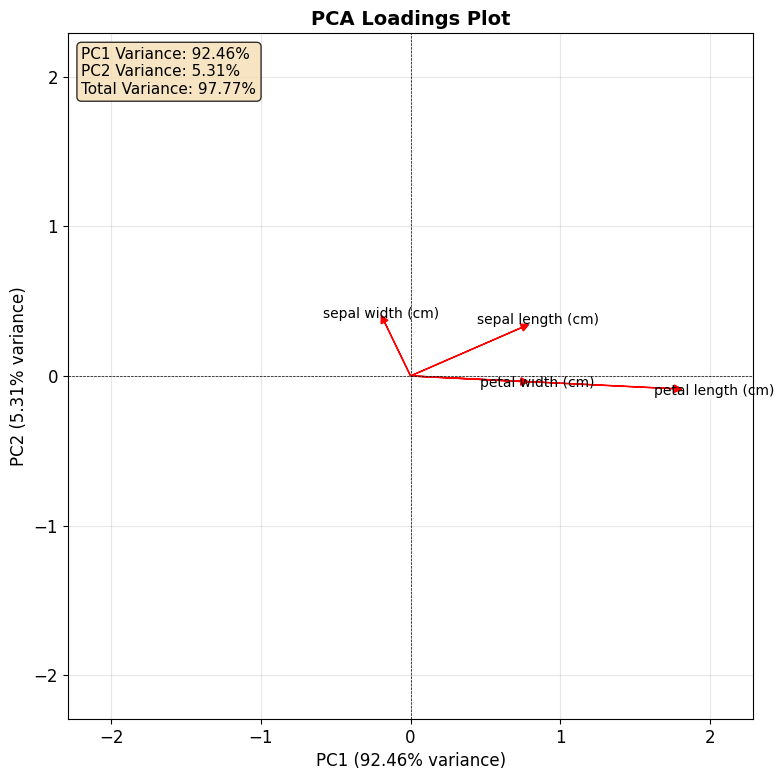

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
plot_pca_loadings(iris_features, iris.feature_names)

<module 'matplotlib.pyplot' from '/home/rafael/gitgud/CounterFactualDPG/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

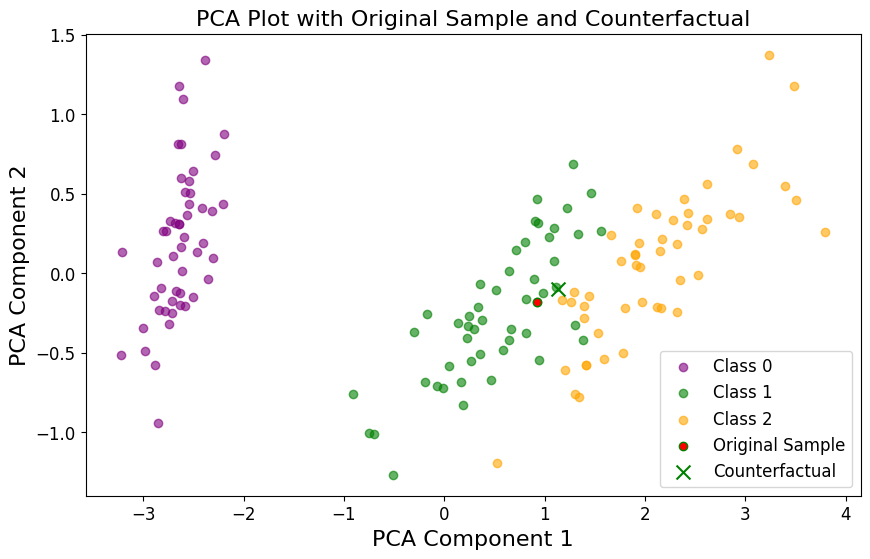

In [33]:
plot_pca_with_counterfactual(model, iris_features, iris_labels, original_sample, counterfactual)

## Generate Counterfactuals with All Rule Combinations

Generating counterfactual with constraints: {'petal width (cm)': 'non_increasing', 'petal length (cm)': 'non_increasing', 'sepal length (cm)': 'non_increasing', 'sepal width (cm)': 'non_increasing'}
Feature 'petal width (cm)' changed from 6.1 to 4.14.
Feature 'petal length (cm)' changed from 2.8 to 0.72.
Feature 'sepal length (cm)' changed from 4.7 to 1.4.
Feature 'sepal width (cm)' changed from 1.2 to 0.
All constraints were respected.
Stopping criteria not set or not reached.
Original class: 1, Counterfactual class: 0
Original fitness: inf, Best fitness: inf
Generating counterfactual with constraints: {'petal width (cm)': 'non_increasing', 'petal length (cm)': 'non_increasing', 'sepal length (cm)': 'non_increasing', 'sepal width (cm)': 'non_decreasing'}
Feature 'petal width (cm)' changed from 6.1 to 4.14.
Feature 'petal length (cm)' changed from 2.8 to 0.72.
Feature 'sepal length (cm)' changed from 4.7 to 1.4.
Feature 'sepal width (cm)' changed from 1.2 to 0.
All constraints were res

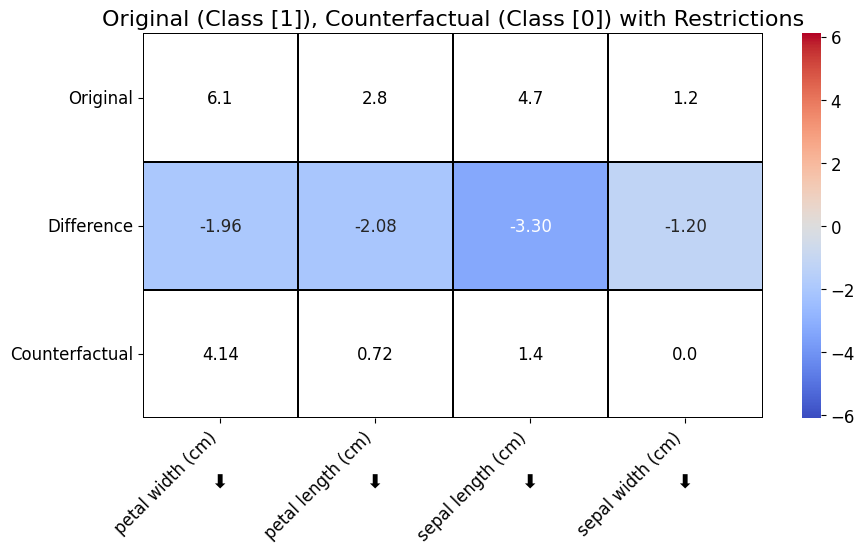

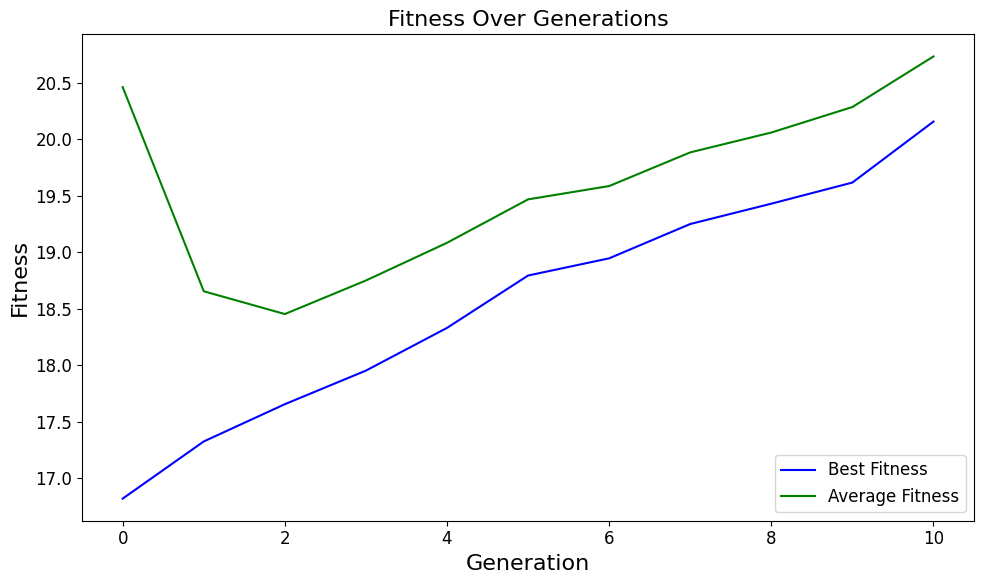

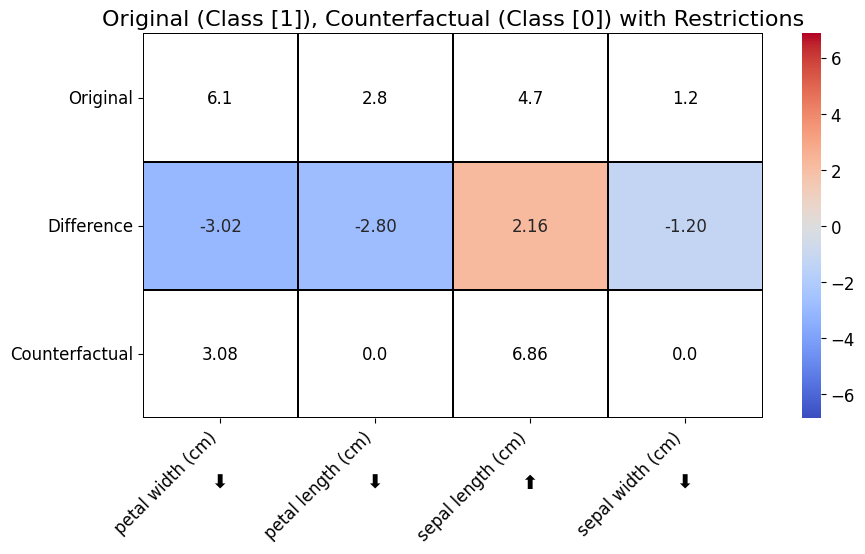

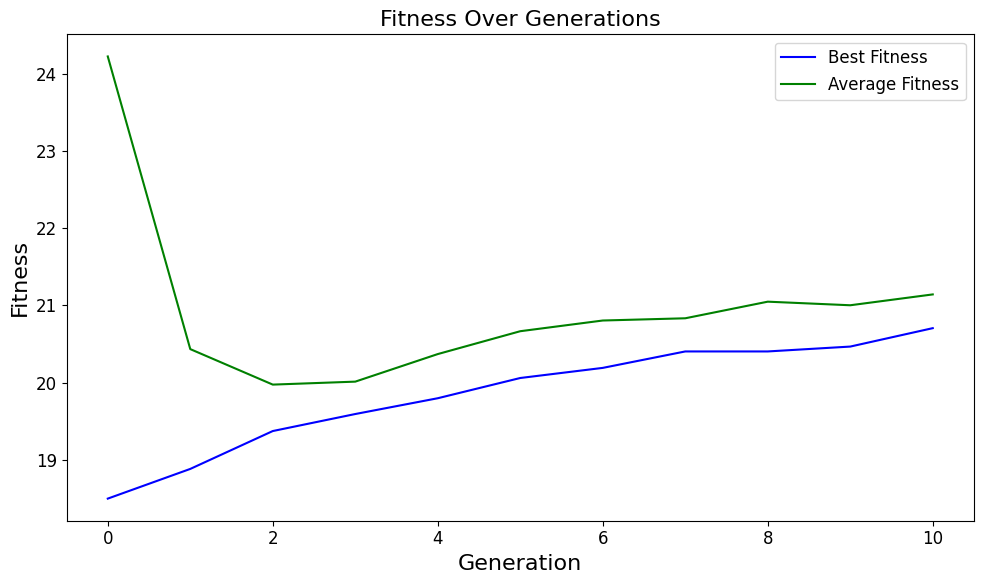

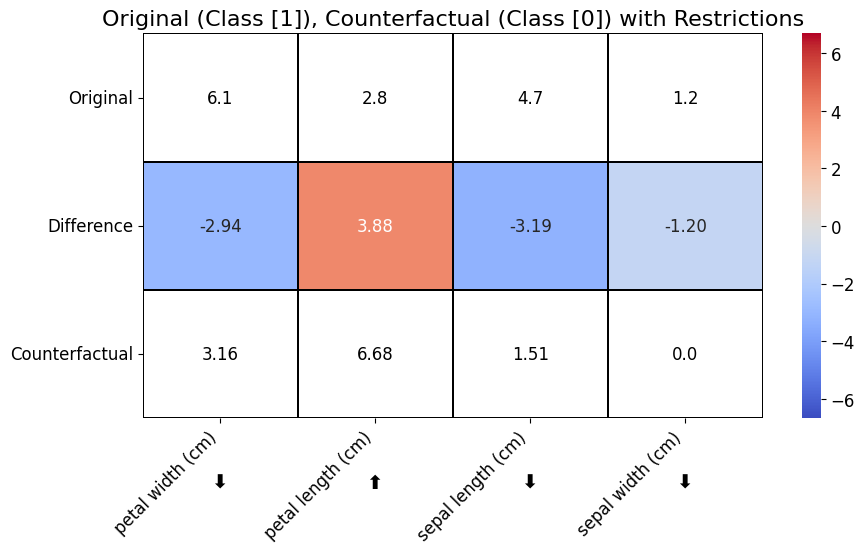

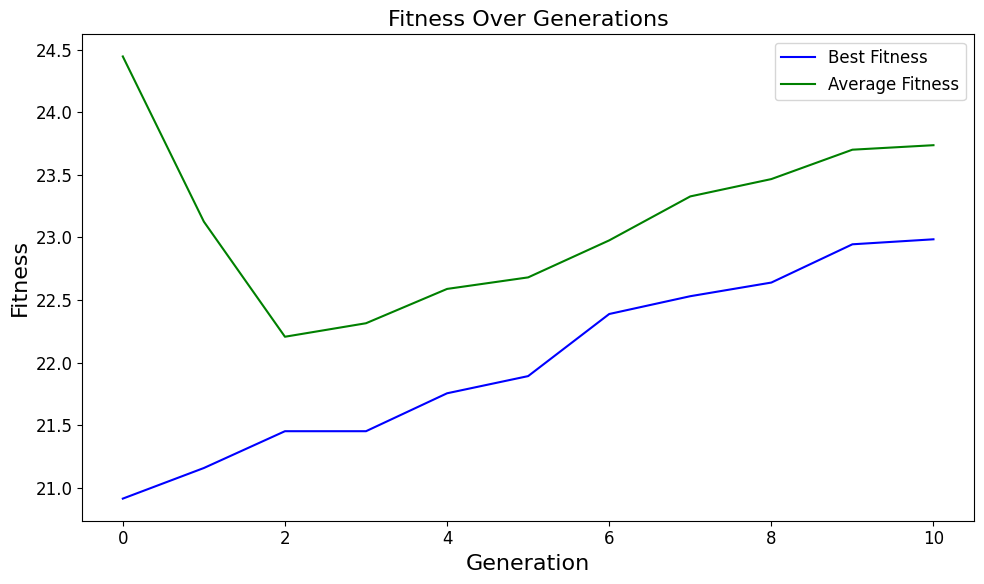

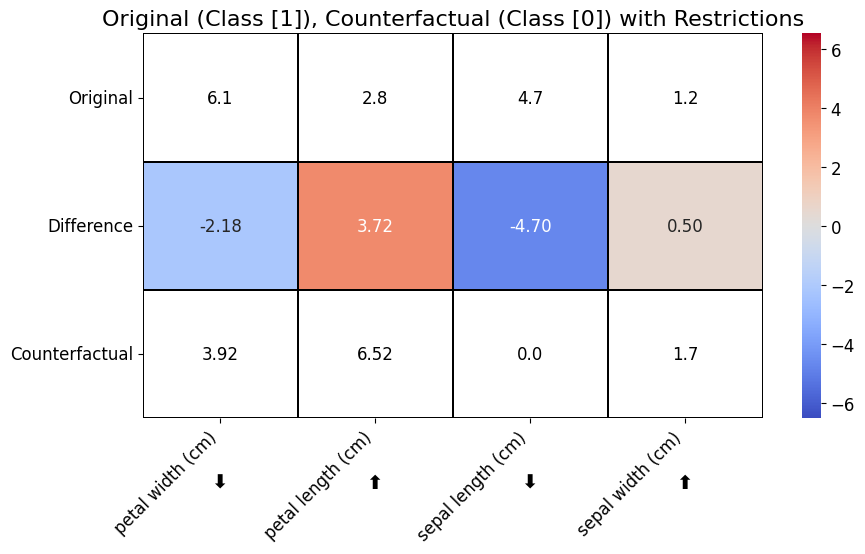

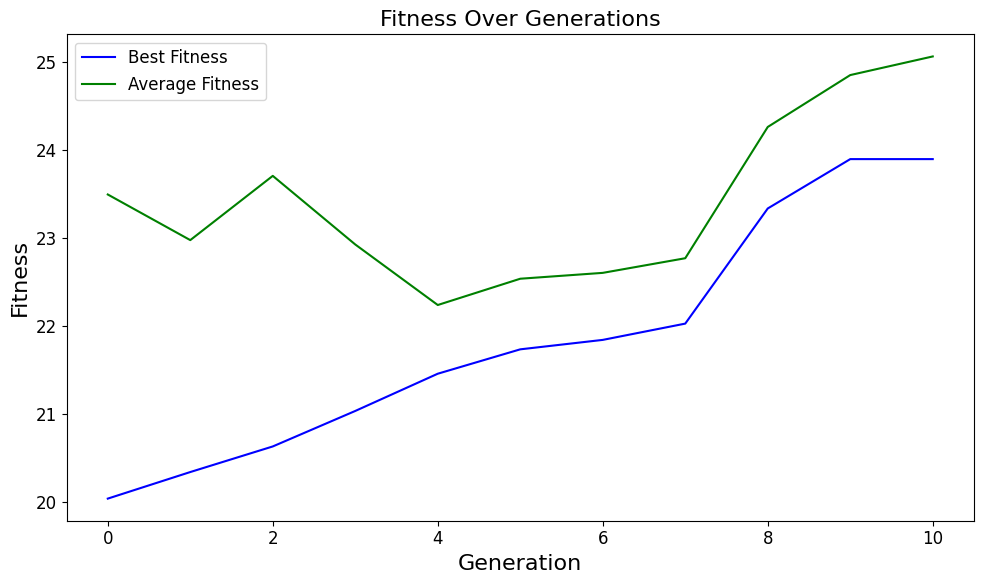

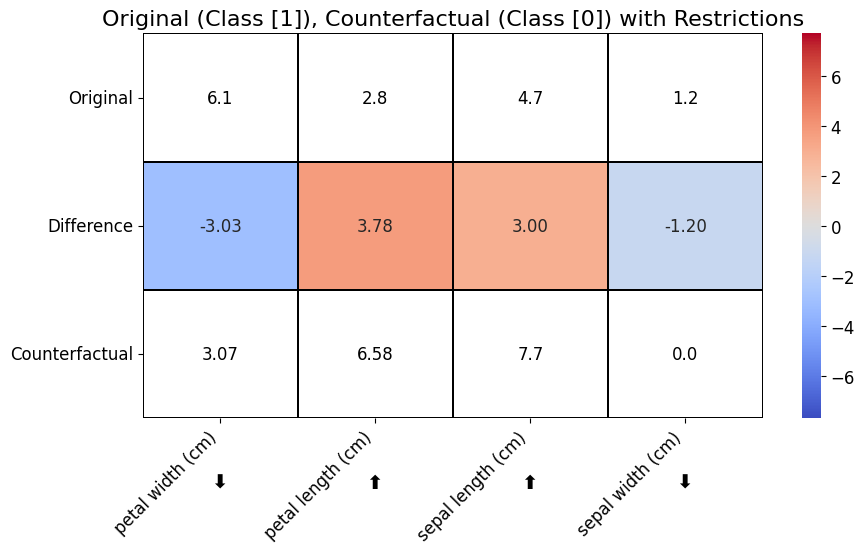

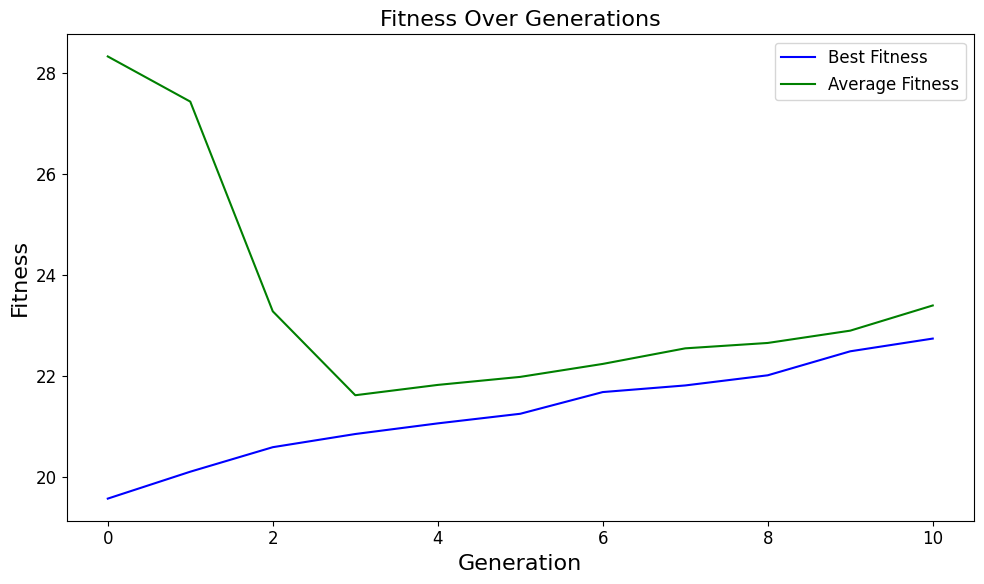

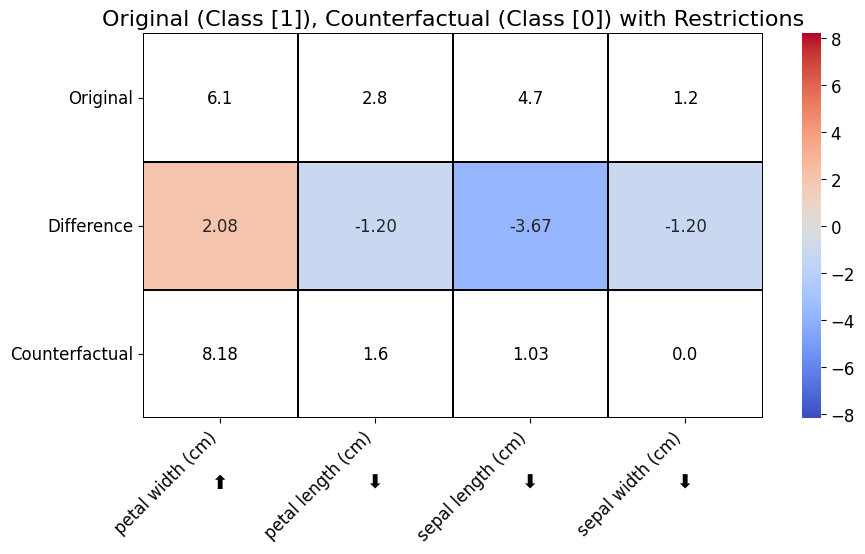

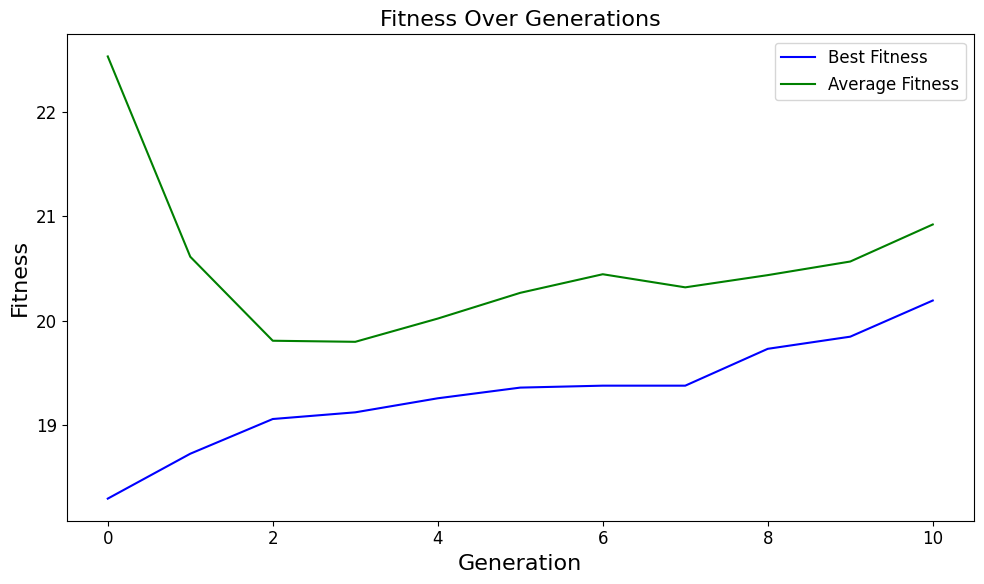

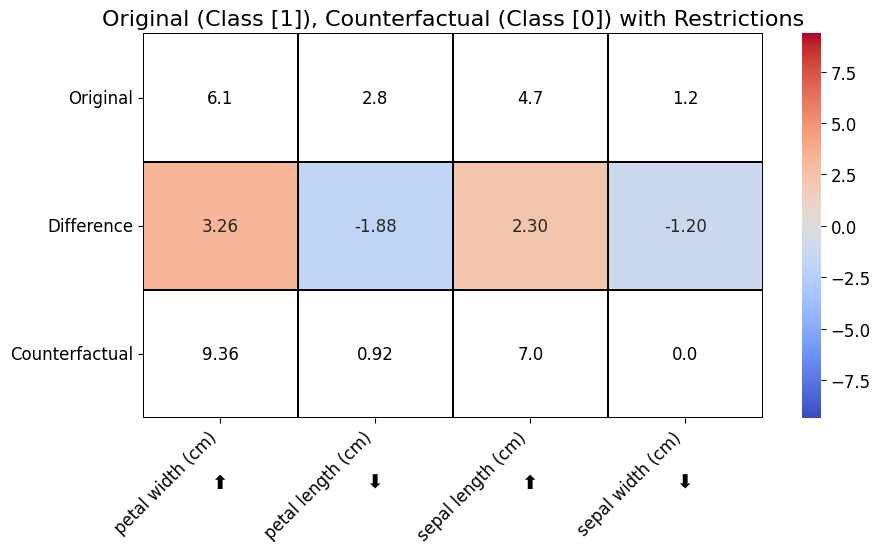

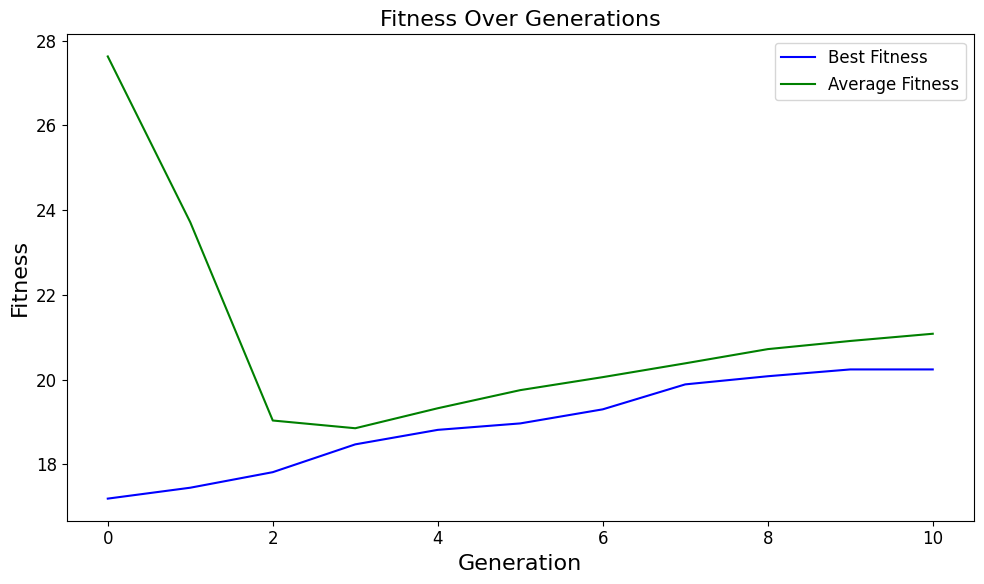

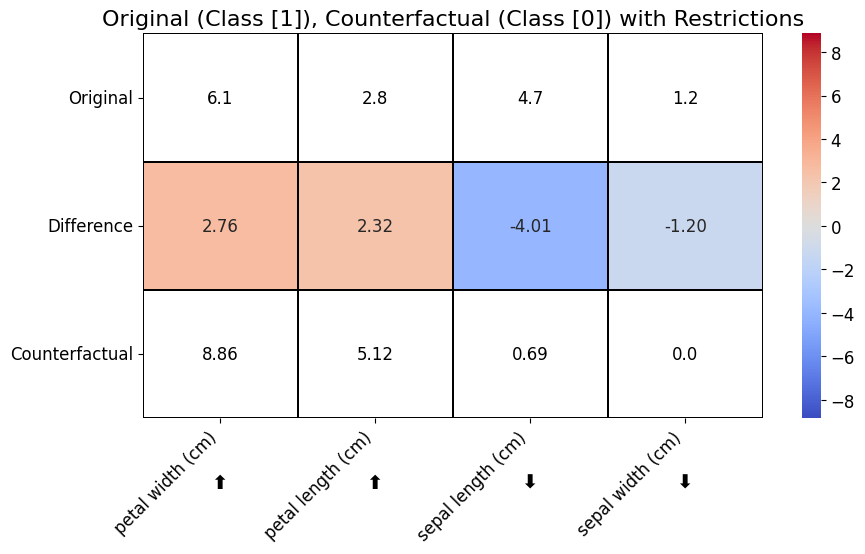

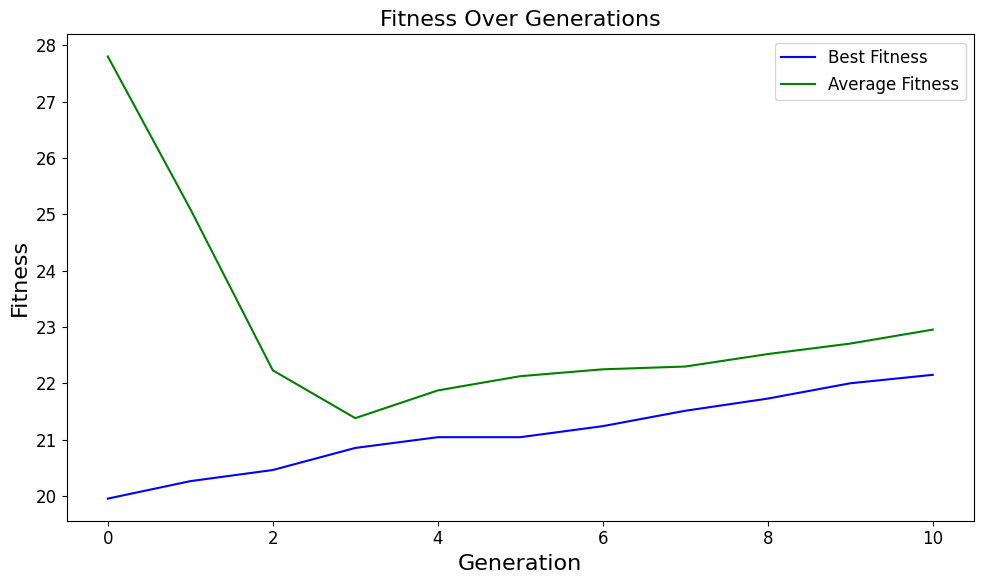

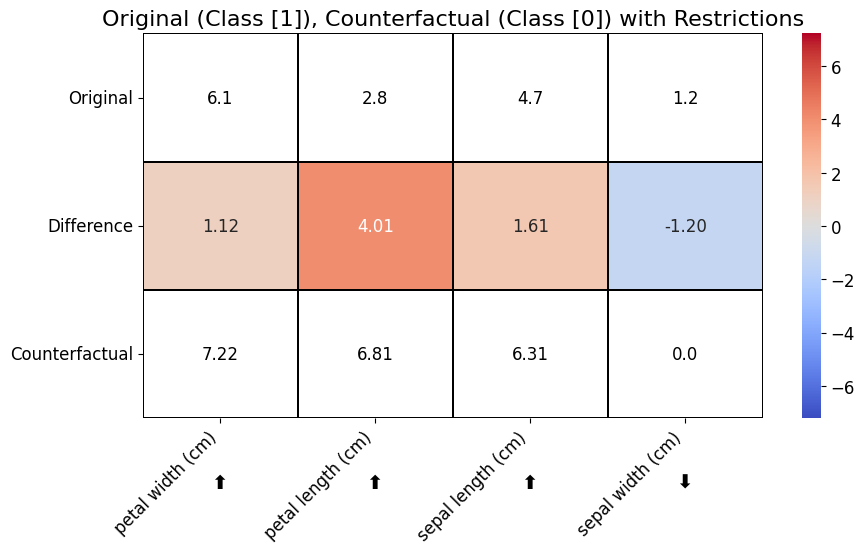

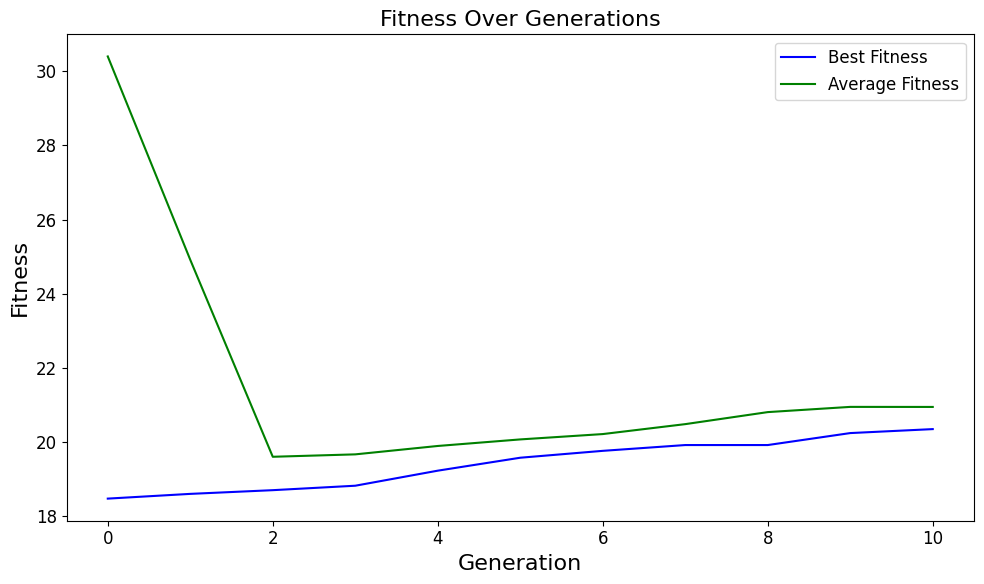

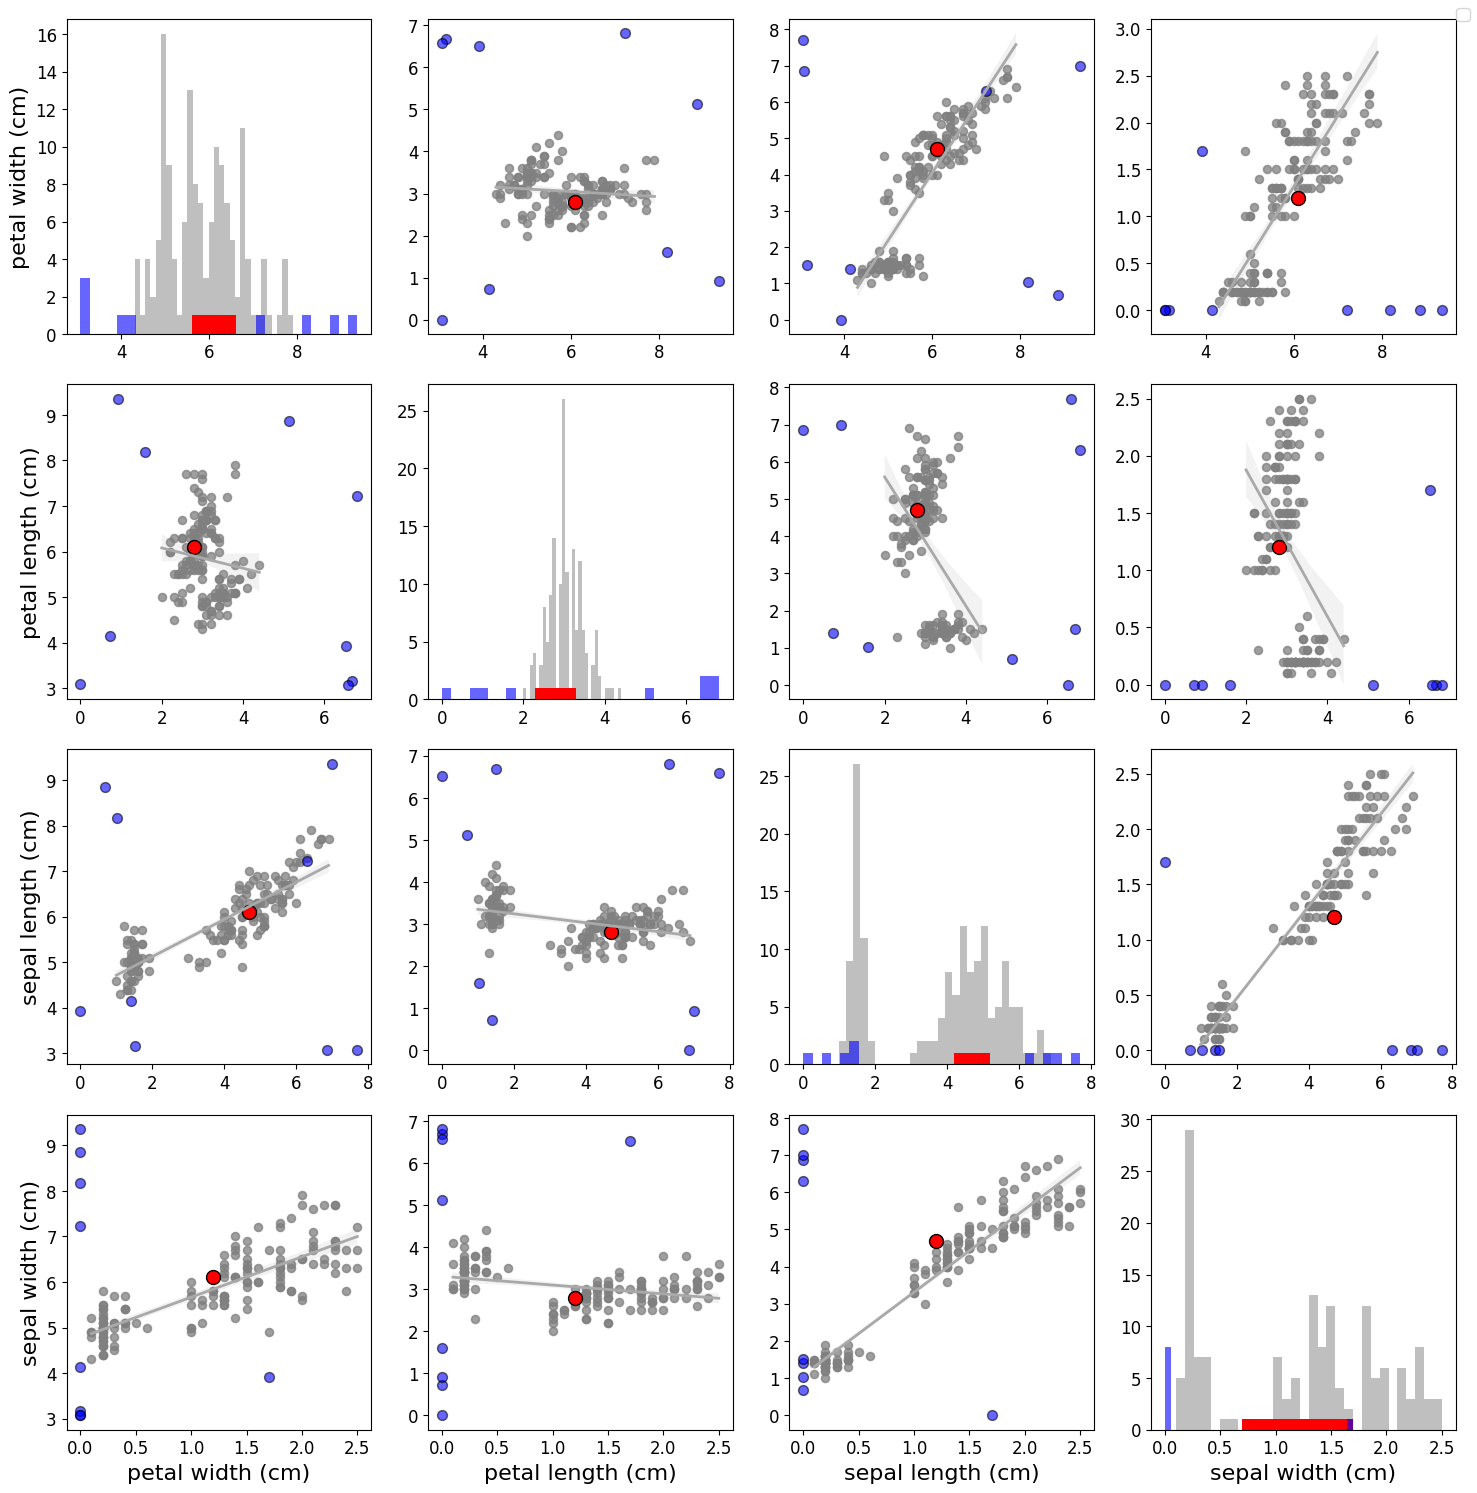

In [34]:
rules = ['no_change', 'non_increasing', 'non_decreasing']
rules = [ 'non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(original_sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df_combinations = []

# Iterate through each combination of rules
for combination in rule_combinations:
    dict_non_actionable = dict(zip(feature_names, combination))
    print(f"Generating counterfactual with constraints: {dict_non_actionable}")
    # Create an instance of the CounterFactualModel class
    cf_dpg = CounterFactualModel(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(original_sample, target_class, 20, 100)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(original_sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)
    cf_dpg.plot_fitness()

    explainer = CounterFactualExplainer(cf_dpg, original_sample, counterfactual, target_class)
    print(explainer.explain_feature_modifications())
    print(explainer.check_constraints_respect())
    print(explainer.explain_stopping_criteria())
    print(explainer.summarize_final_results())


    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df_combinations.append(cf_data)

counterfactuals_df_combinations = pd.DataFrame(counterfactuals_df_combinations)
# Displaying the DataFrame
print(counterfactuals_df_combinations)

plot_pairwise_with_counterfactual_df(model, iris_features, iris_labels, original_sample, counterfactuals_df_combinations)


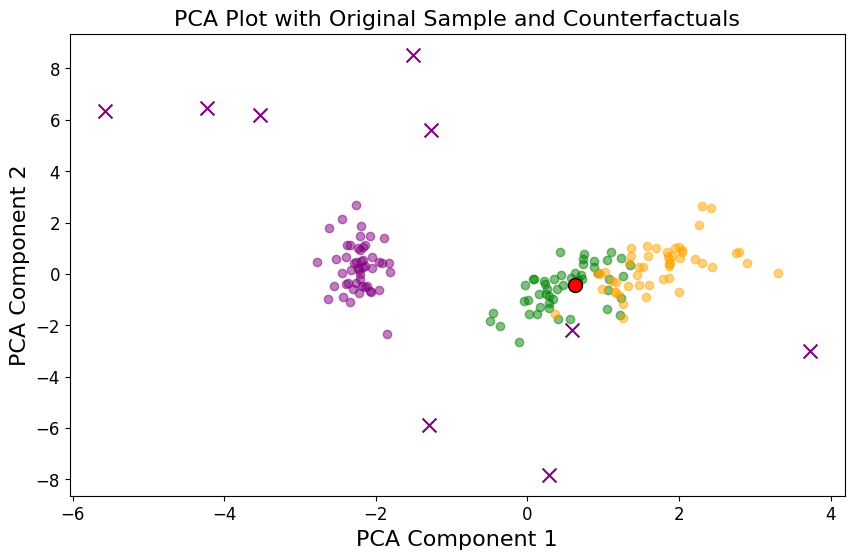

In [35]:
from CounterFactualVisualizer import plot_pca_with_counterfactuals

plot_pca_with_counterfactuals(model, pd.DataFrame(iris_features), iris_labels, original_sample, counterfactuals_df_combinations)